In [1]:
import os
import sys

import argparse
from datetime import datetime
import imageio
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
import numpy as np
from tqdm import tqdm

import make_clean_showers as mcs
from apply_gains import apply_gains
import target_io

In [2]:
@njit
def clean_image(raw_charge: np.ndarray, grid_ind: List, mean_noise: np.ndarray) -> np.ndarray:
    # constant values relating to the proportion of a square covered
    # by part of a circle
    a = 0.2138
    b = 0.479
    c = 0.985

    # corresponds to an aperture with 2 pxl radius
    aperture = [[0., a, b, a, 0.],
                [a, c, 1., c, a],
                [b, 1., 1., 1., b],
                [a, c, 1., c, a],
                [0., a, b, a, 0.]]
    aperture = np.asarray(aperture)
    charge_temp = np.zeros((40, 40))
    raw_charge_copy = raw_charge
    raw_charge_copy[688:704] = 0.0
    raw_charge_copy[192:256] = 0.0
    raw_charge_copy[0:64] = 0.0
    raw_charge_copy[512:576] = 0.0
    for i, val in enumerate(raw_charge_copy):
        charge_temp[grid_ind[i]//40, grid_ind[i]%40] = val 
    noise_temp = np.zeros((40, 40))
    for i, val in enumerate(mean_noise):
        noise_temp[grid_ind[i]//40, grid_ind[i]%40] = val
    charge = np.zeros((44, 44))
    charge[2:42, 2:42] = charge_temp
    noise_pad = np.zeros((44, 44))
    noise_pad[2:42, 2:42] = noise_temp
    image = np.zeros((40, 40))
    for i in range(40):
        for j in range(40):
            if charge[i+2, j+2] == 0.0:
                image[i, j] = 0.0
                continue
            s = np.nansum(charge[i:i+5, j:j+5] * aperture)
            noise = np.nansum(noise_pad[i:i+5, j:j+5] * aperture)
            if s > noise*2:
                image[i, j] = charge[i+2, j+2]
    image[16:24, 16:24] = np.NaN
    return image


In [3]:
mod_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 103, 106, 107,
            108, 111, 112, 114, 115, 119, 121, 123, 124, 125, 126]

mod_nums = [100, 111, 114, 107, 6, 115, 123, 124, 112, 7, 119,
            108, 110, 121, 8, 103, 125, 126, 106, 9, 4, 5, 1, 3, 2]
fpm_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24]

fpm_pos = np.mgrid[0:5, 0:5]
fpm_pos = zip(fpm_pos[0].flatten(), fpm_pos[1].flatten())

mod_to_fpm = dict(zip(mod_nums, fpm_nums))
fpm_to_pos = dict(zip(fpm_nums, fpm_pos))

ch_nums = np.array([[21, 20, 17, 16, 5, 4, 1, 0],
                    [23, 22, 19, 18, 7, 6, 3, 2],
                    [29, 28, 25, 24, 13, 12, 9, 8],
                    [31, 30, 27, 26, 15, 14, 11, 10],
                    [53, 52, 49, 48, 37, 36, 33, 32],
                    [55, 54, 51, 50, 39, 38, 35, 34],
                    [61, 60, 57, 56, 45, 44, 41, 40],
                    [63, 62, 59, 58, 47, 46, 43, 42]])
rot_ch_nums = np.rot90(ch_nums, k=2)
ch_to_pos = dict(zip(ch_nums.reshape(-1), np.arange(64)))
rot_ch_to_pos = dict(zip(rot_ch_nums.reshape(-1), np.arange(64)))

num_columns = 5
total_cells = num_columns * num_columns * 64
indices = np.arange(total_cells).reshape(-1, int(np.sqrt(total_cells)))
grid_ind = List()
for index, mod in enumerate(mod_list):
    i, j = fpm_to_pos[mod_to_fpm[mod]]
    ch_map = dict()
    if j % 2 == 0:
        ch_map = rot_ch_to_pos
    else:
        ch_map = ch_to_pos
    # print(f"Channel Map: {ch_map}")
    j = num_columns - 1 - j
    pix_ind = np.array(indices[
        (8*i):8*(i+1), (8*j):8*(j+1)]).reshape(-1)
    # print(f"Pixel Index: {pix_ind}")
    for asic in range(4):
        for ch in range(16):
            grid_ind.append(int(pix_ind[
                ch_map[asic * 16 + ch]]))

In [4]:
runs = [328629, 328630, 328631]
run_list = []
events = []
for run in runs:
    file_ = f"{run}_gammas_hillas.csv"
    temp_events, _, _, _, _, _, _, _, _, _, _, _, _, _, _, _ = np.loadtxt(file_, delimiter=", ",
                                                                          skiprows=1, unpack=True)
    events.extend(temp_events)
    run_list.extend([run for i in temp_events])

In [5]:
run_ev = [(run, events[i]) for i, run in enumerate(run_list)]

In [6]:
@njit
def hillas(charge_coords):
    """Calculates the Hillas parameters for an event."""
    x = 0
    y = 0
    x2 = 0
    y2 = 0
    xy = 0
    CHARGE = 0
    CHARGE = np.nansum(charge_coords[2])
    if CHARGE == 0.0:
        CHARGE = 1.0
    x = np.nansum(charge_coords[0] * charge_coords[2])
    y = np.nansum(charge_coords[1] * charge_coords[2])
    x2 = np.nansum(charge_coords[0] ** 2 * charge_coords[2])
    y2 = np.nansum(charge_coords[1] ** 2 * charge_coords[2])
    xy = np.nansum(charge_coords[0] * charge_coords[1] * charge_coords[2])

    x /= CHARGE
    y /= CHARGE
    x2 /= CHARGE
    y2 /= CHARGE
    xy /= CHARGE

    S2_x = x2 - x ** 2
    S2_y = y2 - y ** 2
    S_xy = xy - x * y
    d = S2_y - S2_x
    a = (d + np.sqrt(d ** 2 + 4 * S_xy ** 2)) / (2 * S_xy)
    b = y - a * x
    width = np.sqrt((S2_y + a ** 2 * S2_x - 2 * a * S_xy) / (1 + a ** 2))
    length = np.sqrt((S2_x + a ** 2 * S2_y + 2 * a * S_xy) / (1 + a ** 2))
    miss = np.abs(b / np.sqrt(1 + a ** 2))
    dis = np.sqrt(x ** 2 + y ** 2)

    q_coord = (x - charge_coords[0]) * (x / dis) + (y - charge_coords[1]) * (y / dis)
    q = np.nansum(q_coord * charge_coords[2]) / CHARGE
    q2 = np.nansum(q_coord ** 2 * charge_coords[2]) / CHARGE
    azwidth = q2 - q ** 2
    alpha = np.arcsin(miss / dis)
    return [x, y, width, length, miss, dis, azwidth, alpha]

In [84]:
%matplotlib inline
def camera_image(image, run, ev, timestr, h_params, keep=False):
    maxZ = np.nanmax(image)
    fig = plt.gcf()
    if fig.get_size_inches().all() == np.array([18., 15.]).all():
        plt.close(fig)
        fig = plt.figure(figsize=(18, 15))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.04, hspace=0.04)

    for i in range(5):
        for j in range(5):
            sub_image = image[i*8:i*8+8, j*8:j*8+8]
            ax = plt.subplot(gs[4 - i, j])
            c = ax.pcolormesh(sub_image, vmin=0, vmax=maxZ, cmap="viridis")
            ax.axis("off")
            ax.set_aspect("equal")
            if i == 4 and j == 4:
                #circle = Circle((0, 0), radius=1, clip_on=False, edgecolor="orange", fill=False)
                #print(h_params)
                x = h_params[0]
                y = h_params[1]
                x0 = h_params[0]
                y0 = h_params[1]
                width = 2*h_params[2] 
                length = 2*h_params[3]
                alpha = h_params[-1]
                psi = np.abs(np.arctan(x0/y0))
                if x0 * y0 < 0.:
                    beta = np.degrees(psi - alpha)
                elif x0 >= 0. and y0 >= 0.:
                    beta = np.degrees(psi - alpha)
                elif x0 < 0. and y0 < 0.:
                    beta = np.degrees(psi + alpha)
                x0 += -12 - 0.42 * 2
                y0 += -12 - 0.32 * 2
                if y >= 0. and x >= 0.:
                    ellipse = Ellipse((x0, y0), width=width, 
                                       height=length, angle=-beta, clip_on=False, edgecolor="red", 
                                       fill=False, linewidth=3)
                elif y >= 0. and x < 0.:
                    ellipse = Ellipse((x0, y0), width=width, 
                                       height=length, angle=beta, clip_on=False, edgecolor="red", 
                                       fill=False, linewidth=3)
                elif y < 0. and x >= 0.:
                    ellipse = Ellipse((x0, y0), width=width, 
                                       height=length, angle=beta, clip_on=False, edgecolor="red", 
                                       fill=False, linewidth=3)
                else:
                    ellipse = Ellipse((x0, y0), width=width, 
                                       height=length, angle=-beta, clip_on=False, edgecolor="red", 
                                       fill=False, linewidth=3)
                orx = -12 - 0.42 * 2
                ory = -12 - 0.32 * 2
                if y >= 0. and x >= 0.:
                    gamma = np.radians(90. + beta)
                if y >= 0. and x <= 0.:
                    gamma = np.radians(90. + beta)
                if y < 0. and x >= 0.:
                    gamma = np.radians(90. - beta)
                elif y < 0. and x < 0.:
                    gamma = np.radians(90. - beta)
                    #gamma = 45. - (gamma - 45.)
                #gamma = np.radians(90. - np.abs(beta))
                #x1 = np.sign(x0) * length * np.cos(gamma) + x0
                x1 = -np.sign(x) * length * np.cos(gamma) + x0
                y1 = (length * np.sin(gamma) + y0)
                #x2 = x0 - np.sign(x0) * length * np.cos(gamma)
                x2 = x0 + np.sign(x) * length * np.cos(gamma)
                y2 = (y0 - length * np.sin(gamma))
                dis = lines.Line2D([orx, x0], [ory, y0], clip_on=False, color="orange", linewidth=3, linestyle="--")
                maj = lines.Line2D([x1, x2], [y1, y2], clip_on=False, color="orange", linewidth=3, linestyle="-")
                #ax.add_line(dis)
                #ax.add_patch(ellipse)
                ax.add_line(maj)

    fig.subplots_adjust(right=0.8, top=0.9, bottom=0.1)
    cbar_ax = fig.add_axes([0.81, 0.1, 0.03, 0.8])
    cbar = fig.colorbar(c, cax=cbar_ax)
    #cbar.set_label("Charge (Photoelectrons)", rotation=270,
    #               size=40, labelpad=40, color="red")
    #ticks = cbar.locator()
    #pad_ticks = [str(int(tick)).rjust(3, r" ") for tick in ticks]
    #cbar_ax.set_yticklabels(pad_ticks)
    cbar_ax.tick_params(labelsize=40)
    ax.text(14.51, -2.5, "Charge (Photoelectrons)", rotation=270, fontsize=40)
    ev = str(ev).rjust(6, "0")
    fig.suptitle(f"Prototype Schwarzschild-Couder Telescope Gamma Rays\nRun {run} Event {ev} ({timestr})", fontsize=39)
    #fig.suptitle(f"x: {x}, y: {y}", fontsize=24)
    if keep is True:
        fig.savefig(f"gamma_animation_hillas_v2/run{run}_ev{ev}.png")

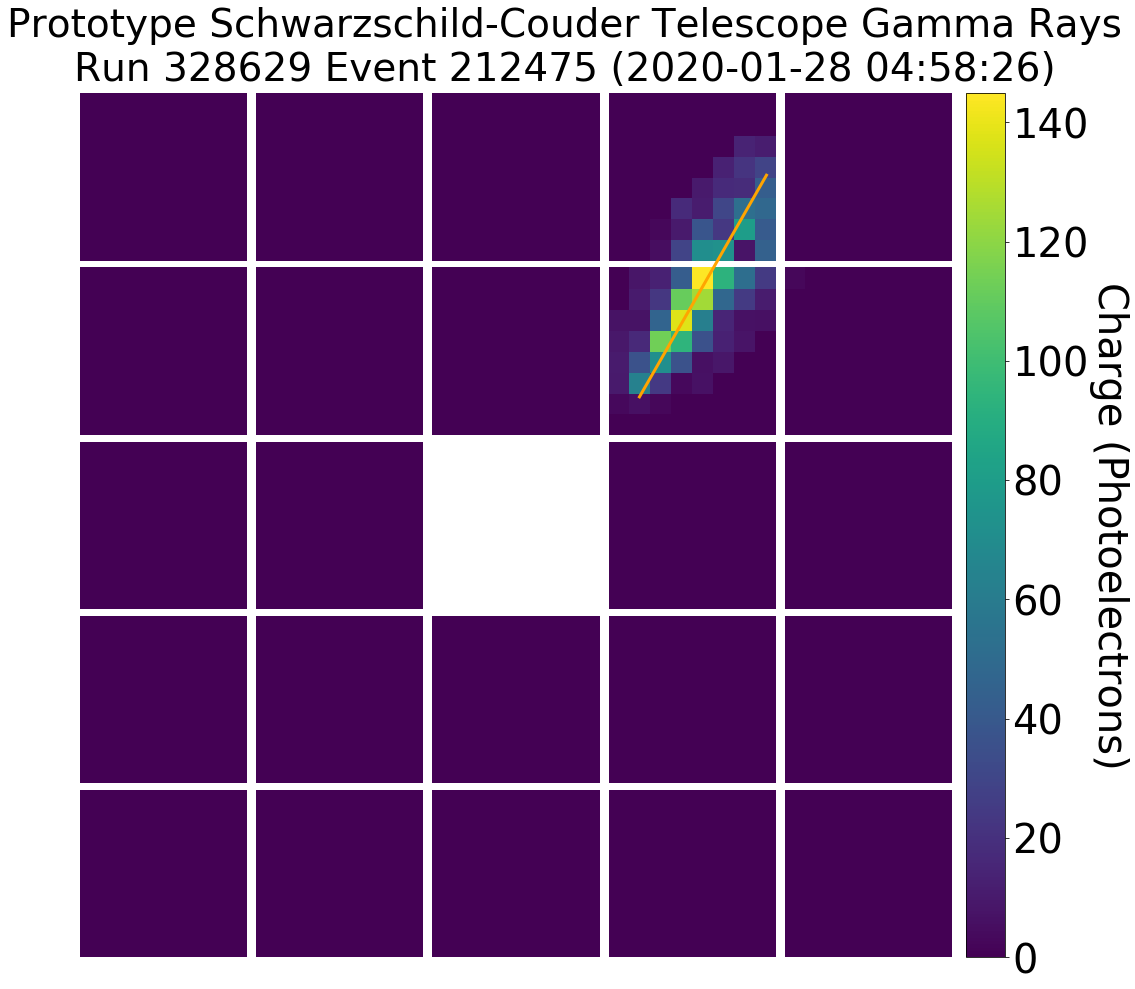

In [85]:
noise_averages = np.load("noise_averages.npz")["arr_0"]
ind = 5
reader = target_io.WaveformArrayReader(f"/home/bmode/cam_data/cal{run_ev[ind][0]}.r1")
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
reader.GetR1Event(int(run_ev[ind][1]), waveforms)
reader.GetTimeStamp(int(run_ev[ind][1]))
time_stamp = int(reader.fCPU_s)
time_str = datetime.utcfromtimestamp(time_stamp).strftime("%Y-%m-%d %H:%M:%S")
peak_positions = np.argmax(waveforms, axis=1)
charges = mcs.calculate_charge(waveforms, peak_positions, n_samples)
charges = apply_gains(charges)
image = clean_image(charges, grid_ind, noise_averages)
charge_coords = [[i - 19.5 + 0.42 * ((i // 8) - 2), 
                  j - 19.5 + 0.32 * ((j // 8) - 2),
                  image[j, i]] 
                  for i in range(40) for j in range(40)]
h_params = hillas(np.asarray(charge_coords).T)
camera_image(image, run_ev[ind][0], int(run_ev[ind][1]), time_str, h_params)
plt.show()

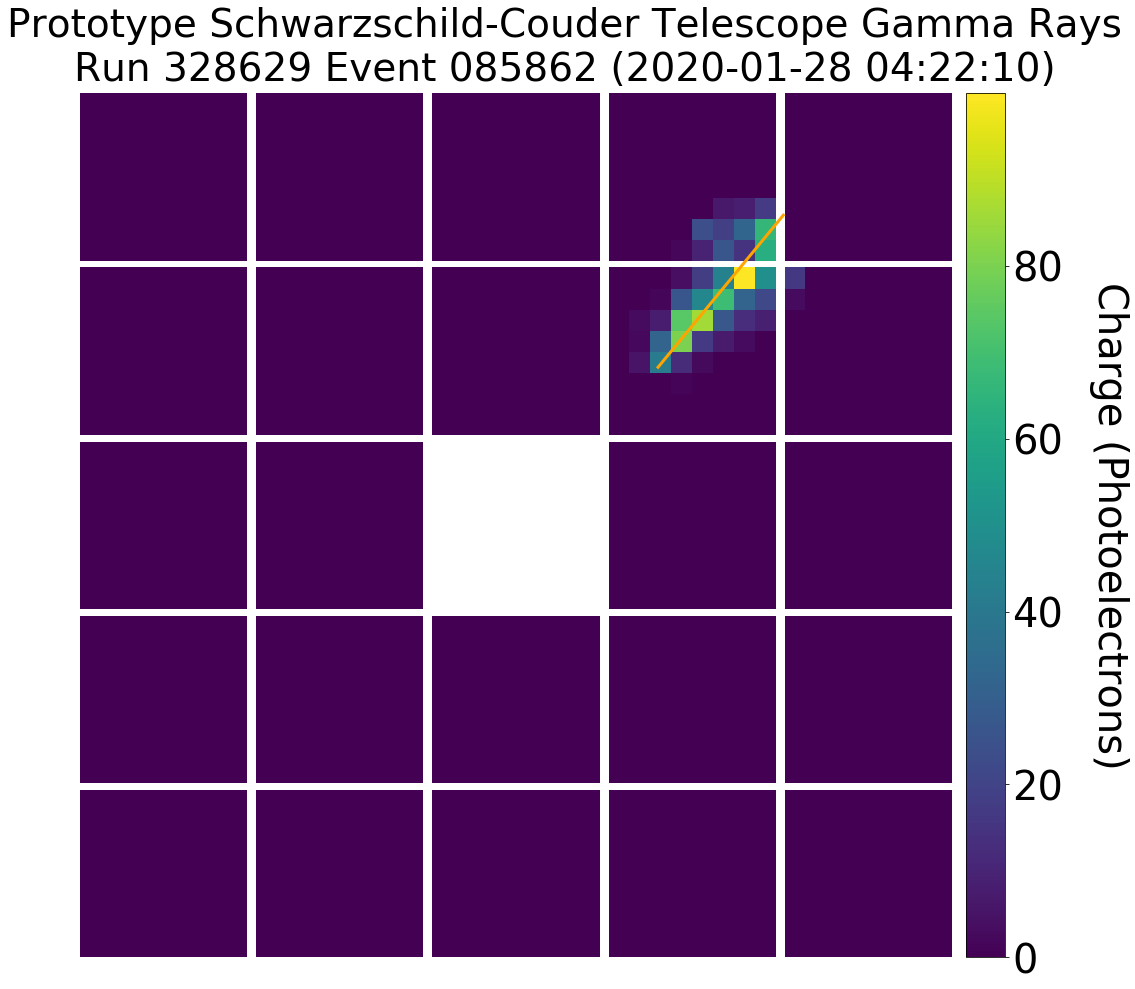

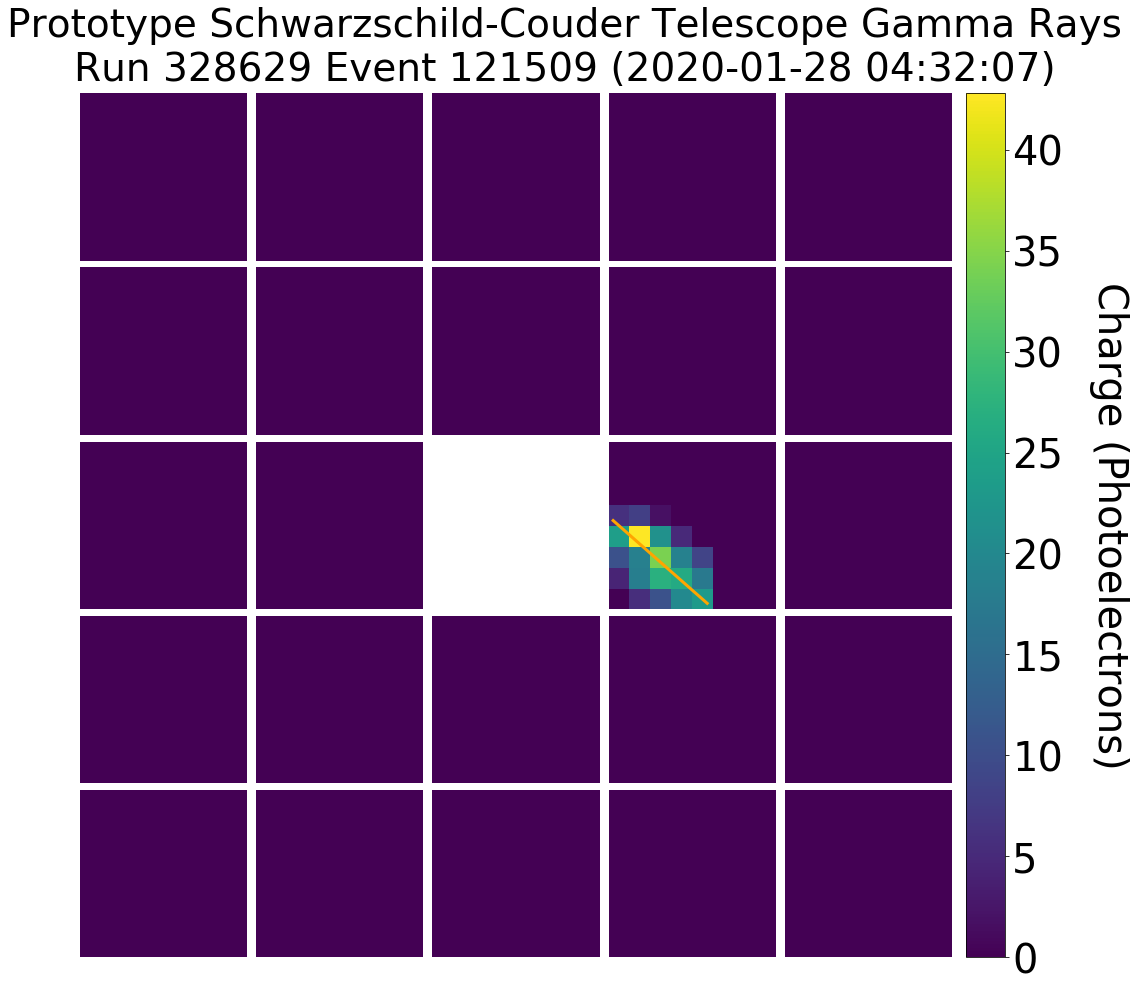

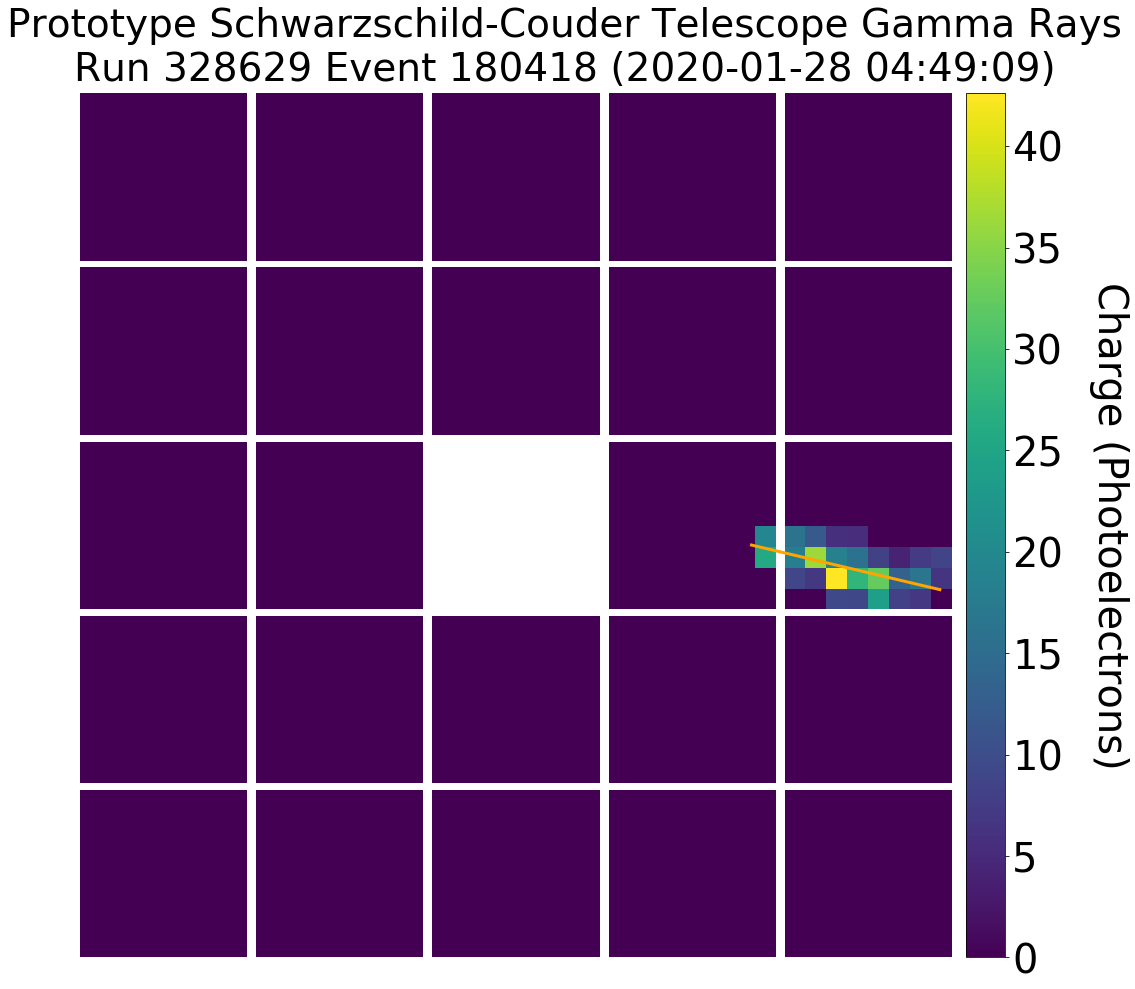

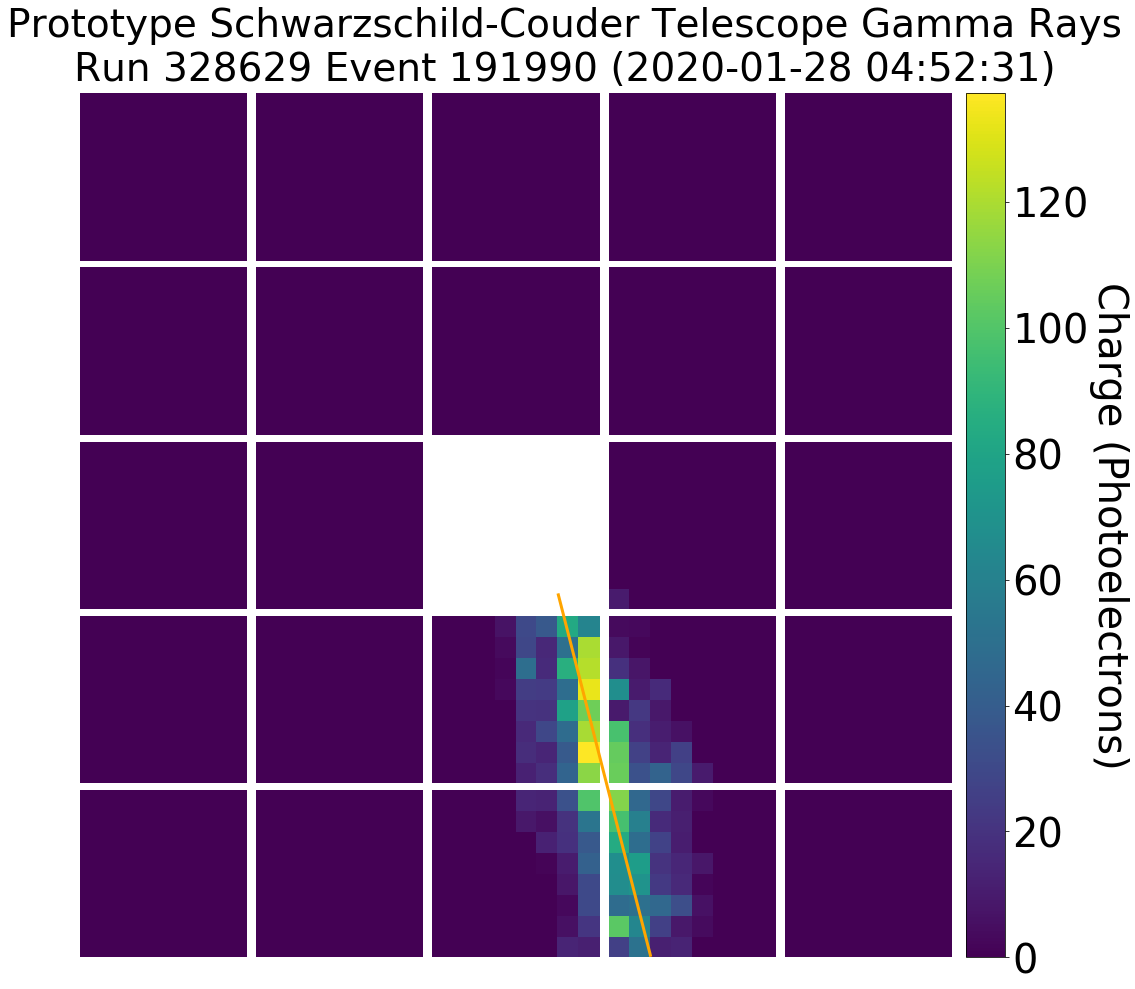

(328629, 201231.0)


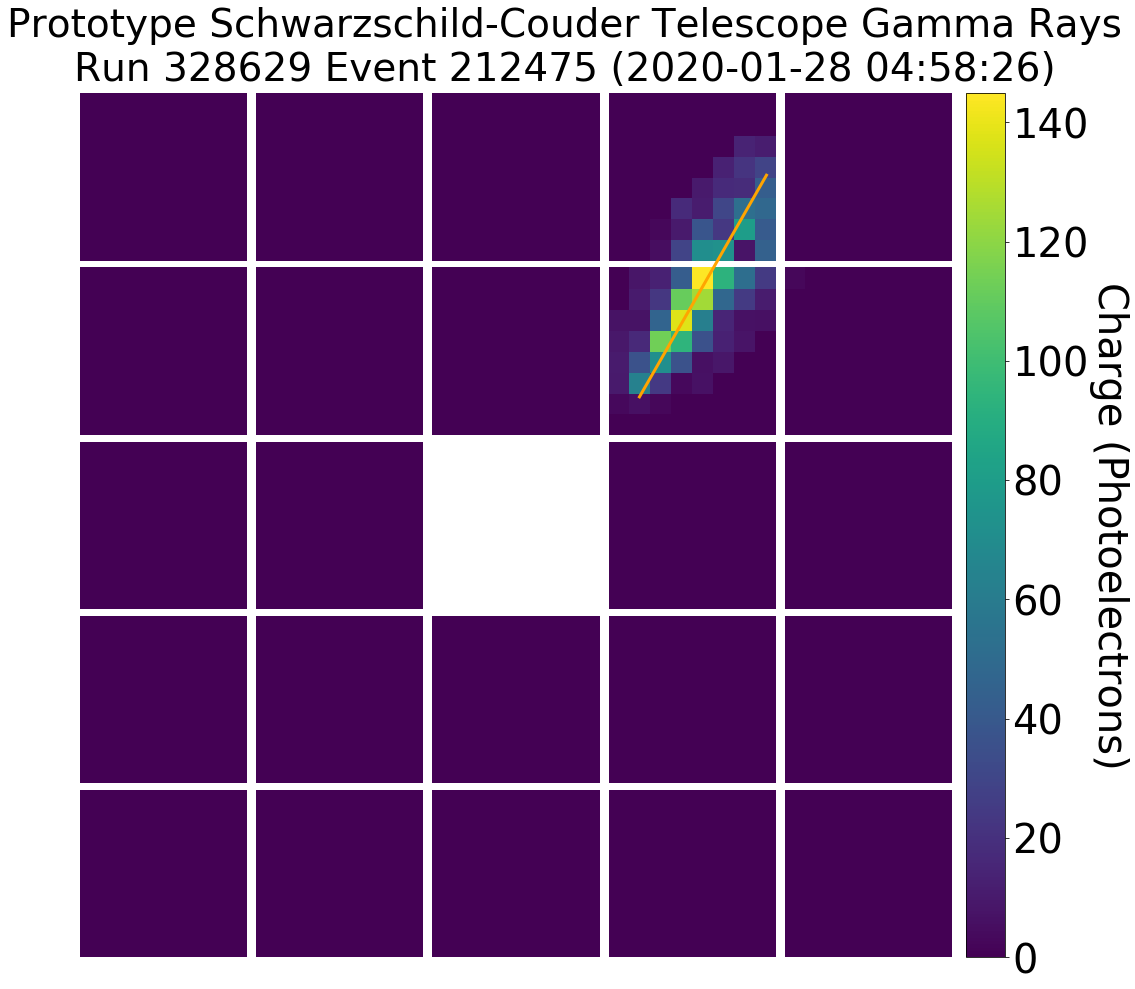

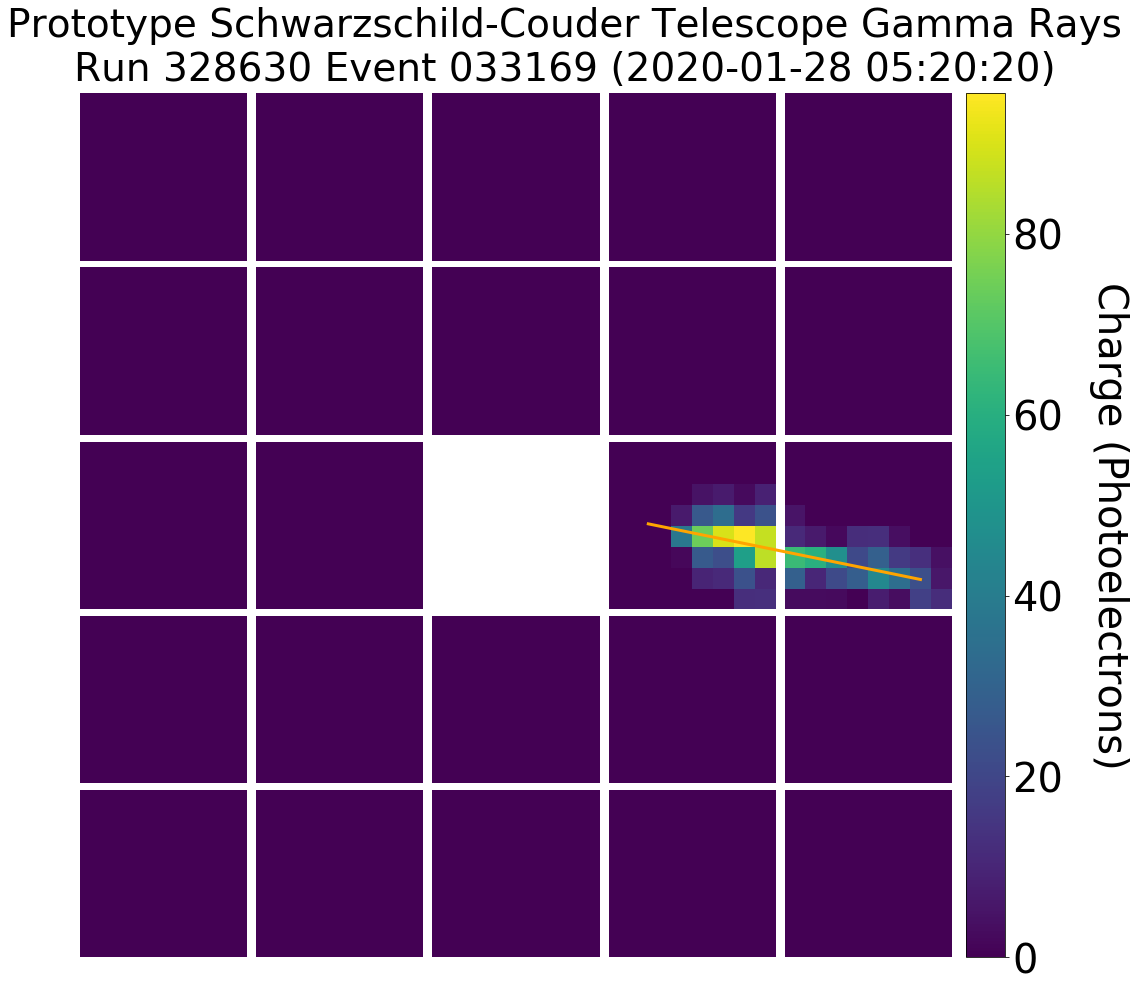

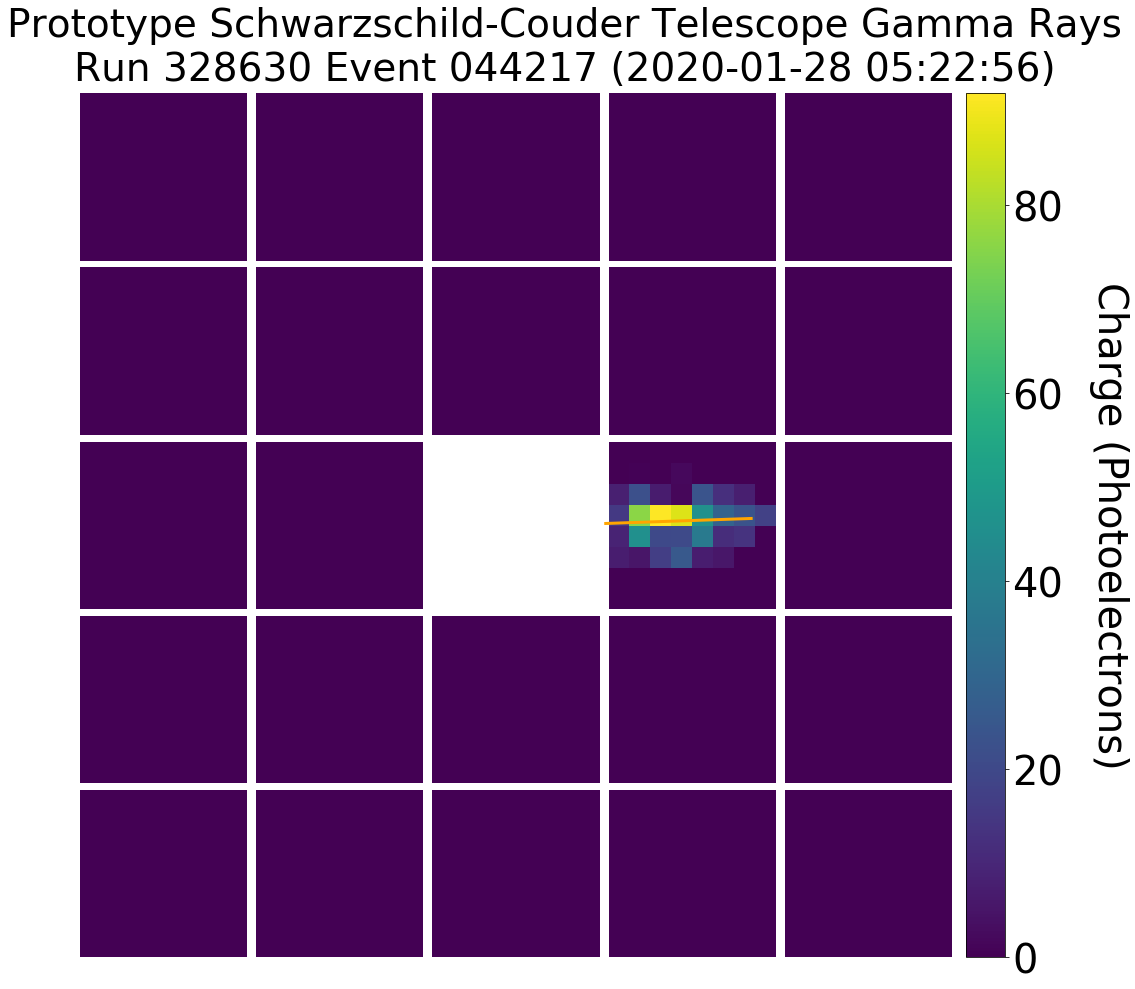

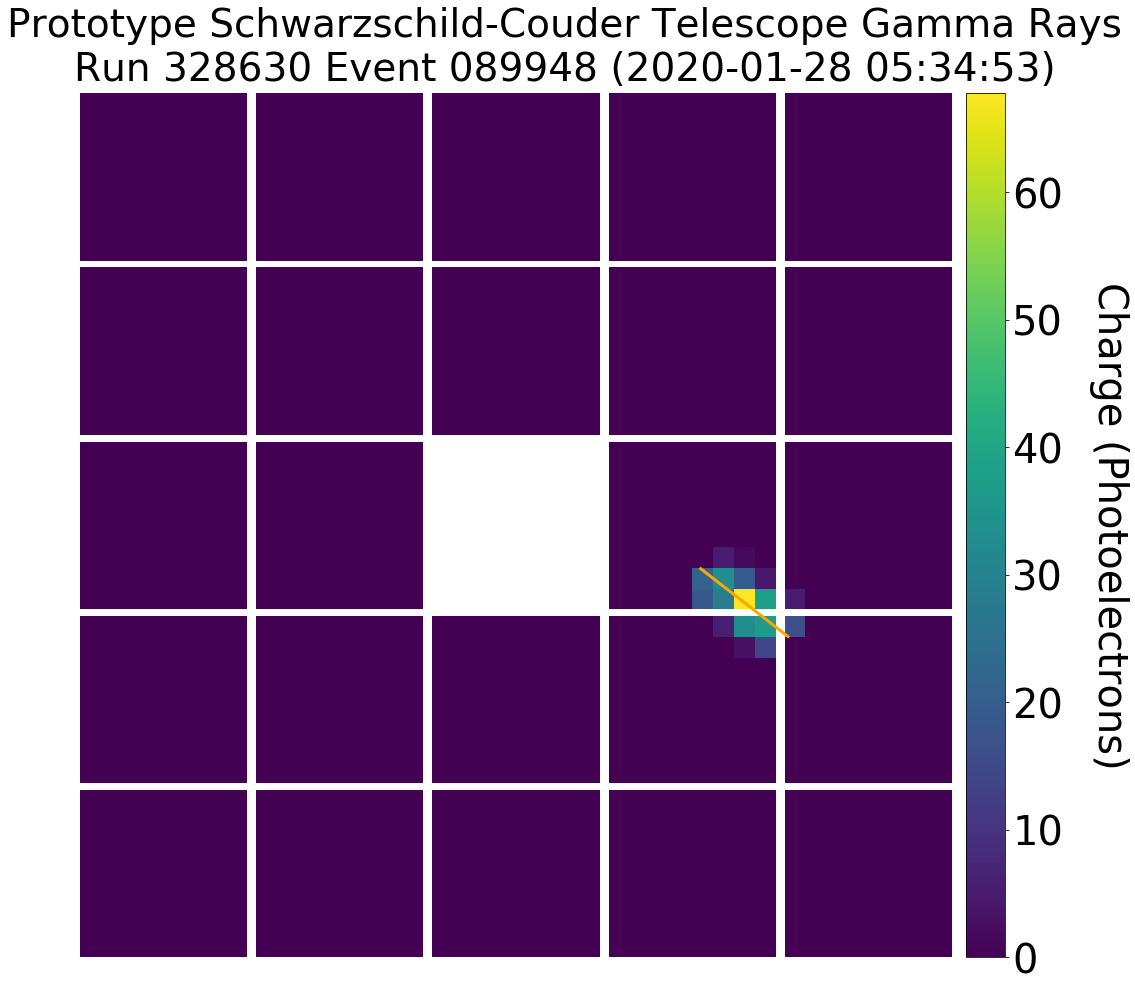

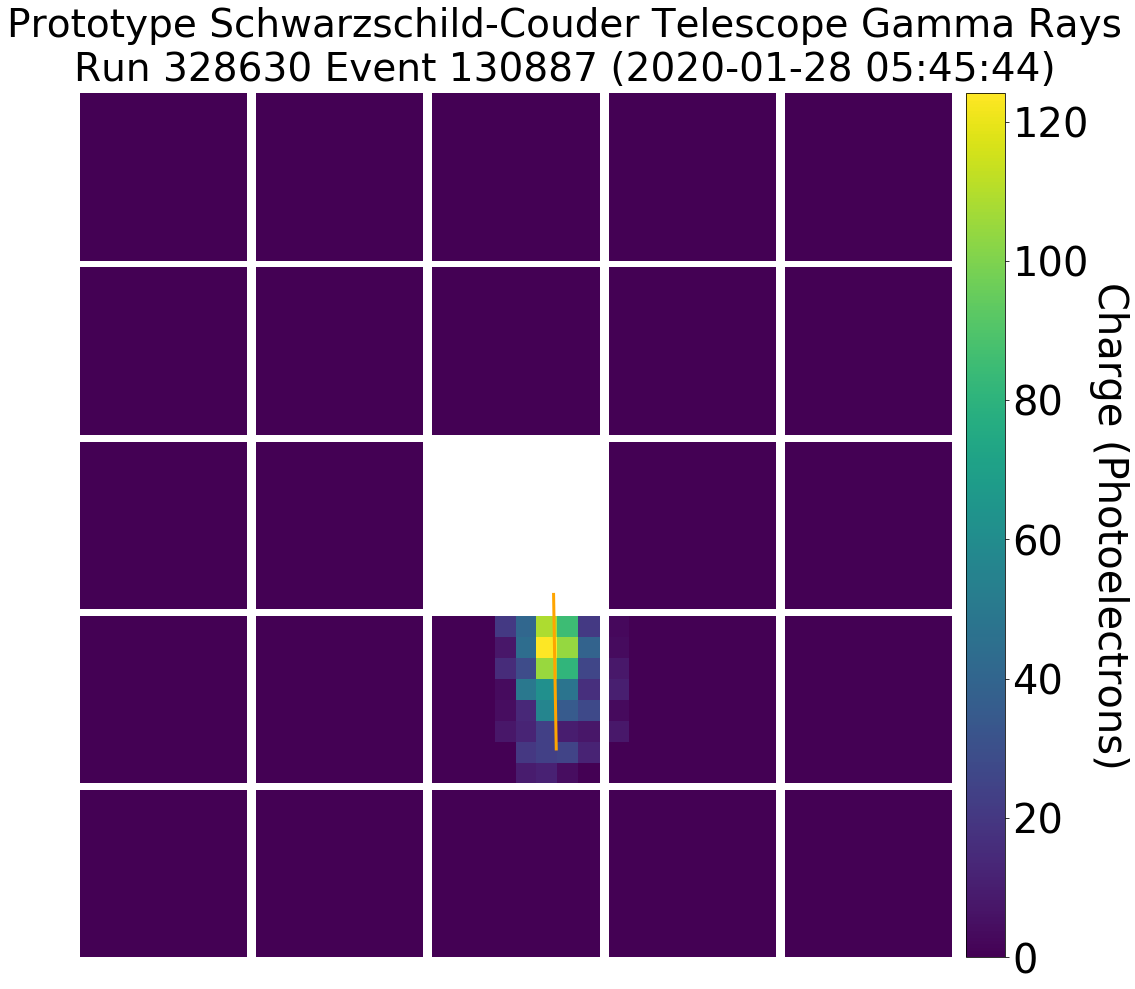

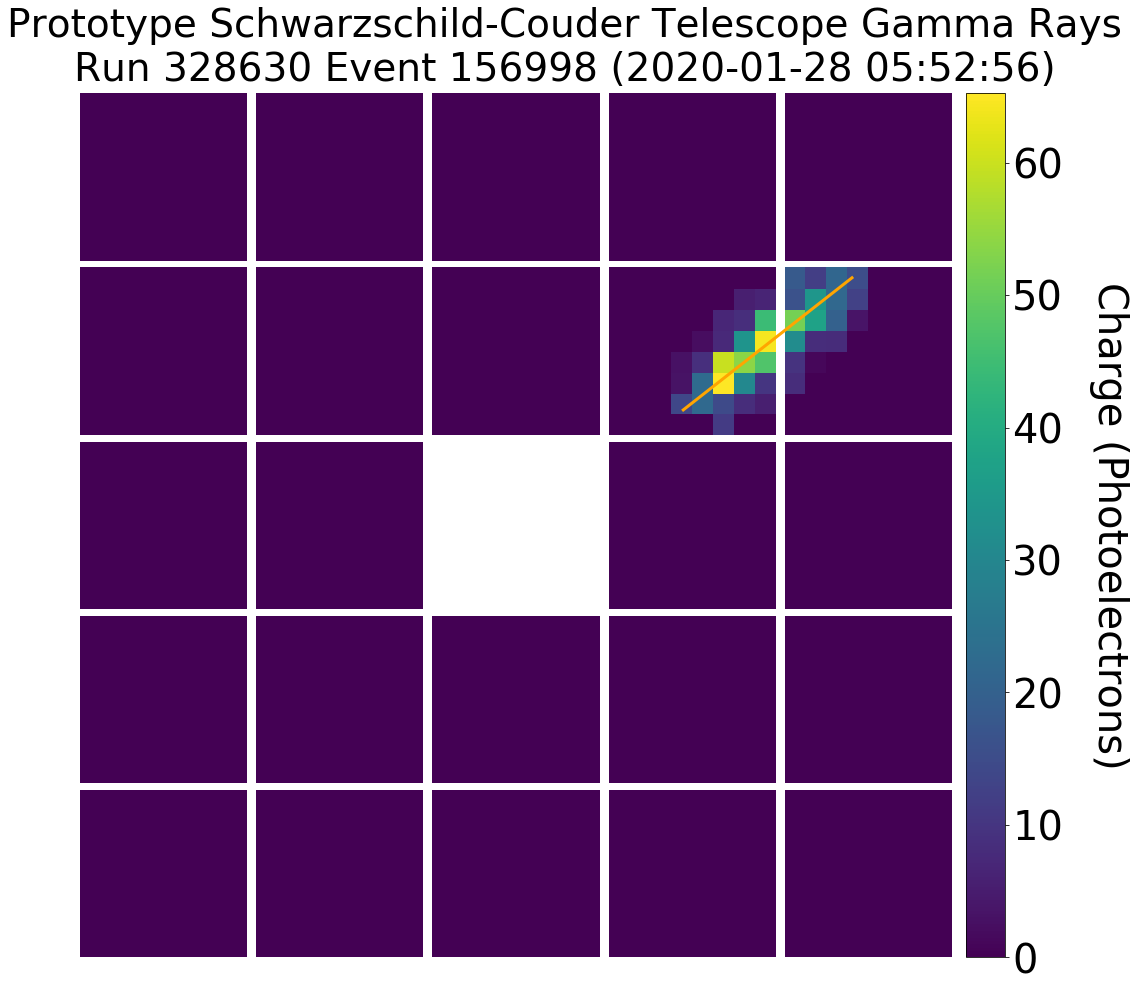

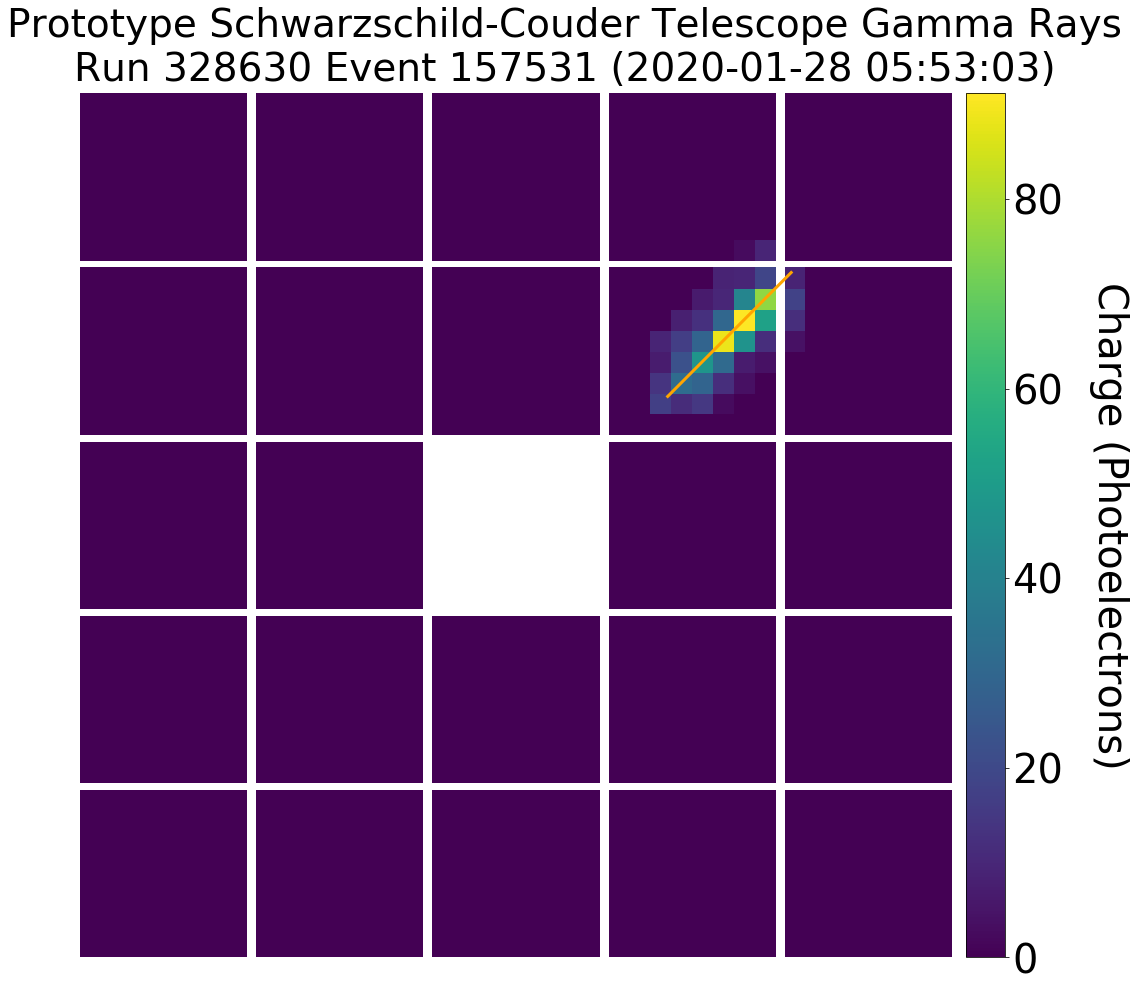

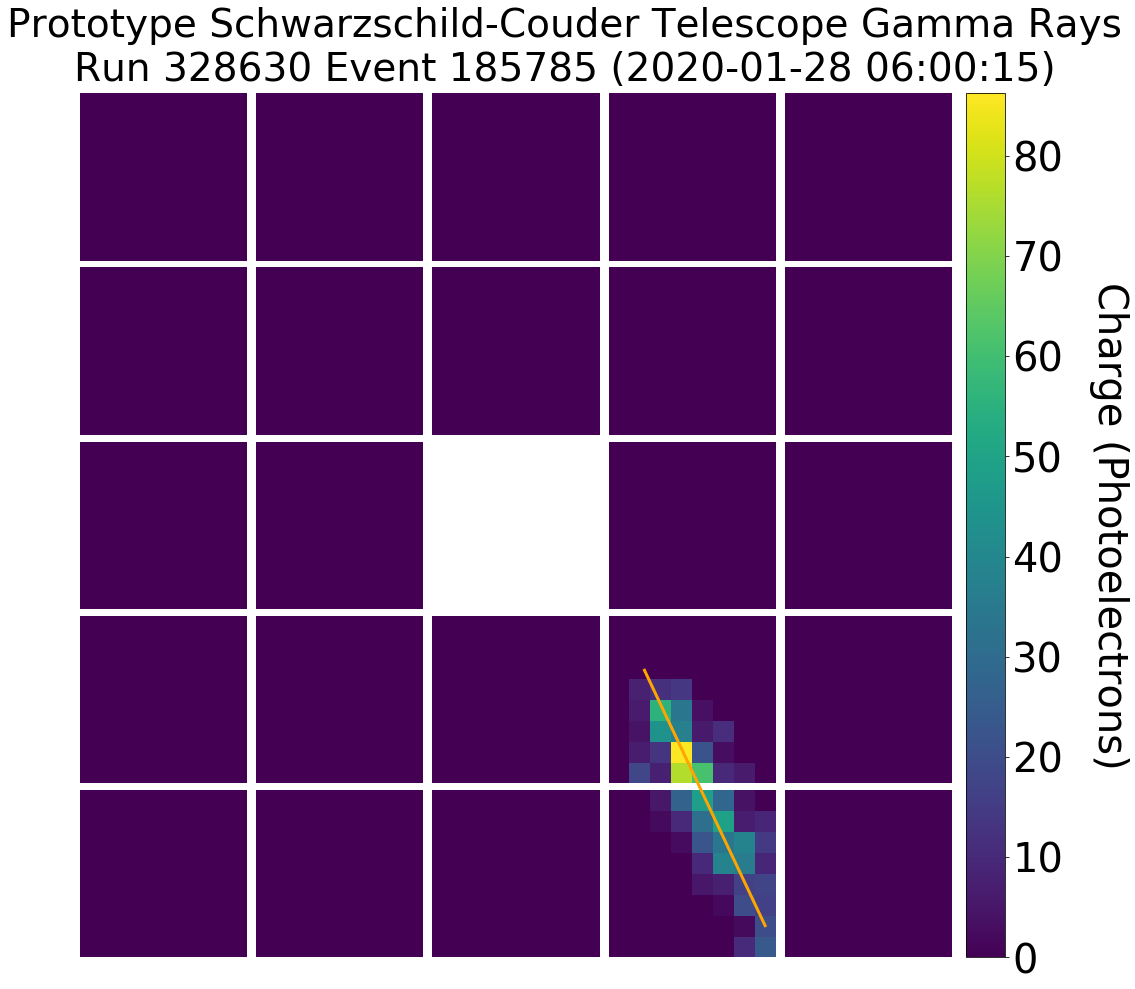

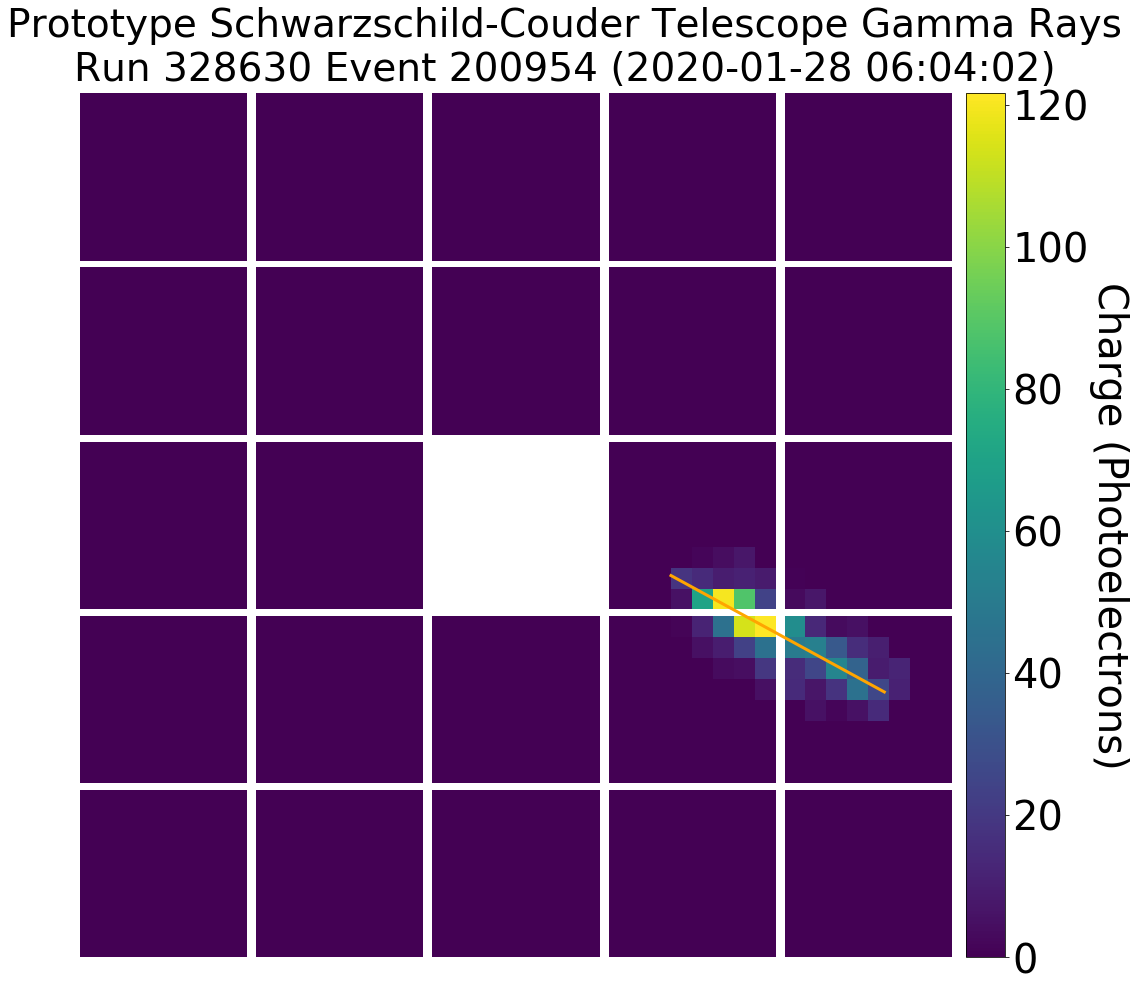

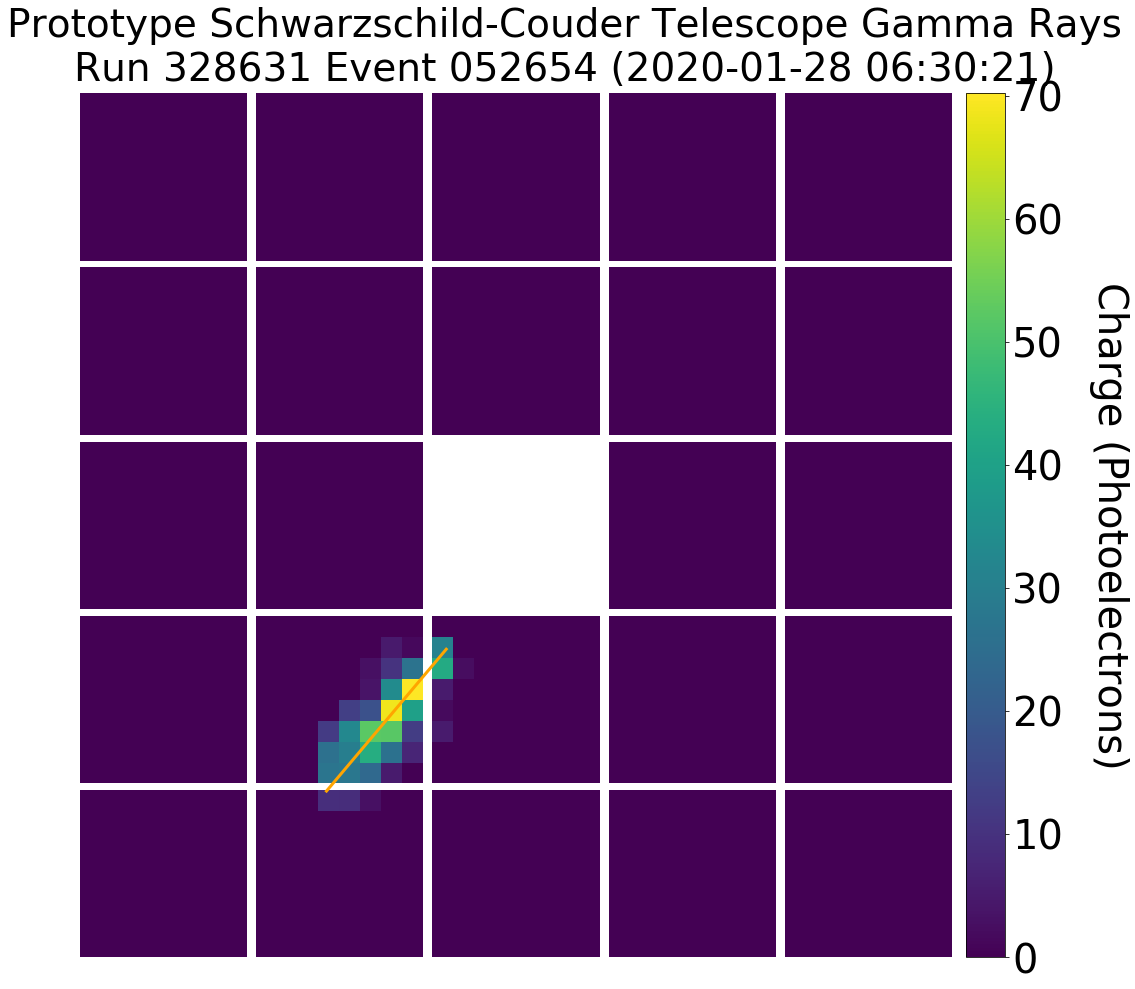

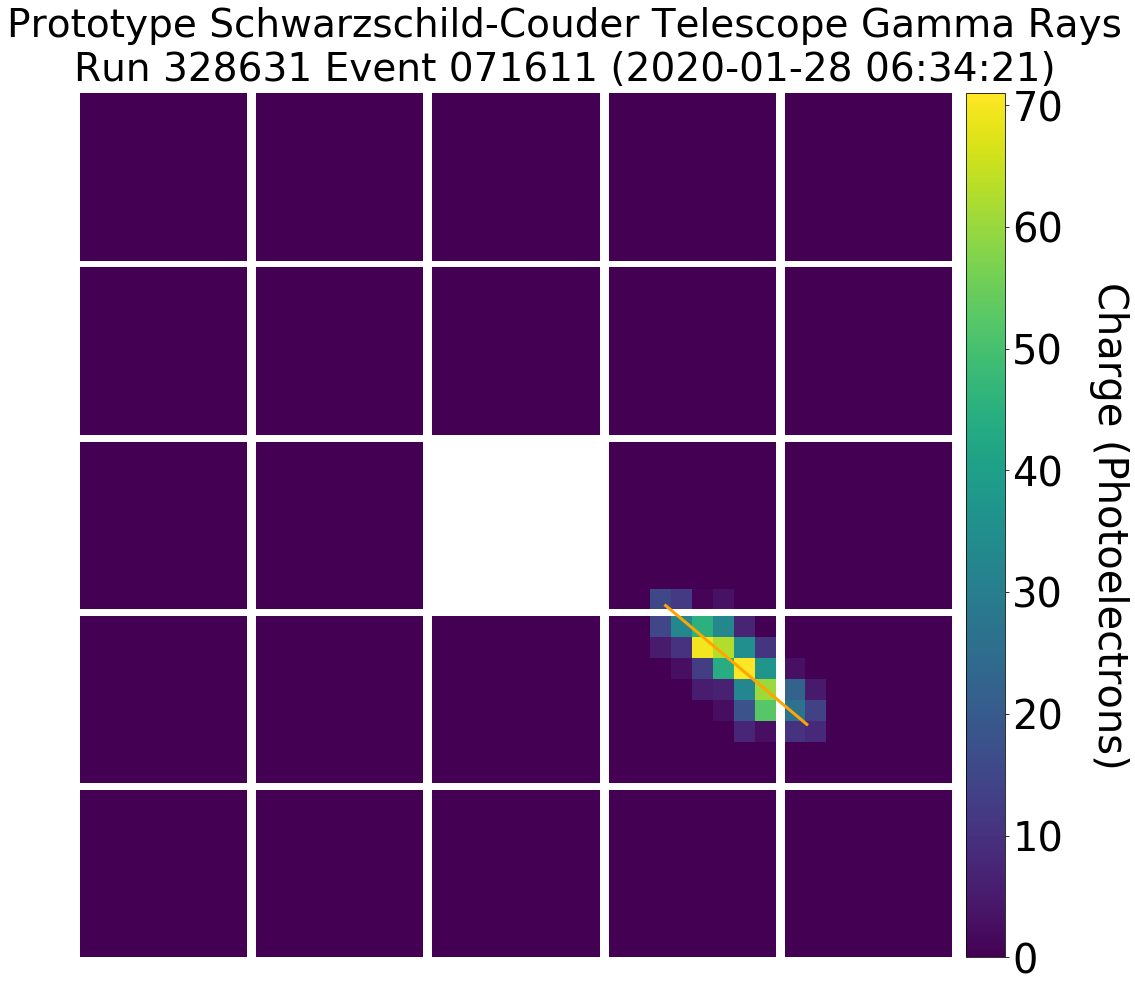

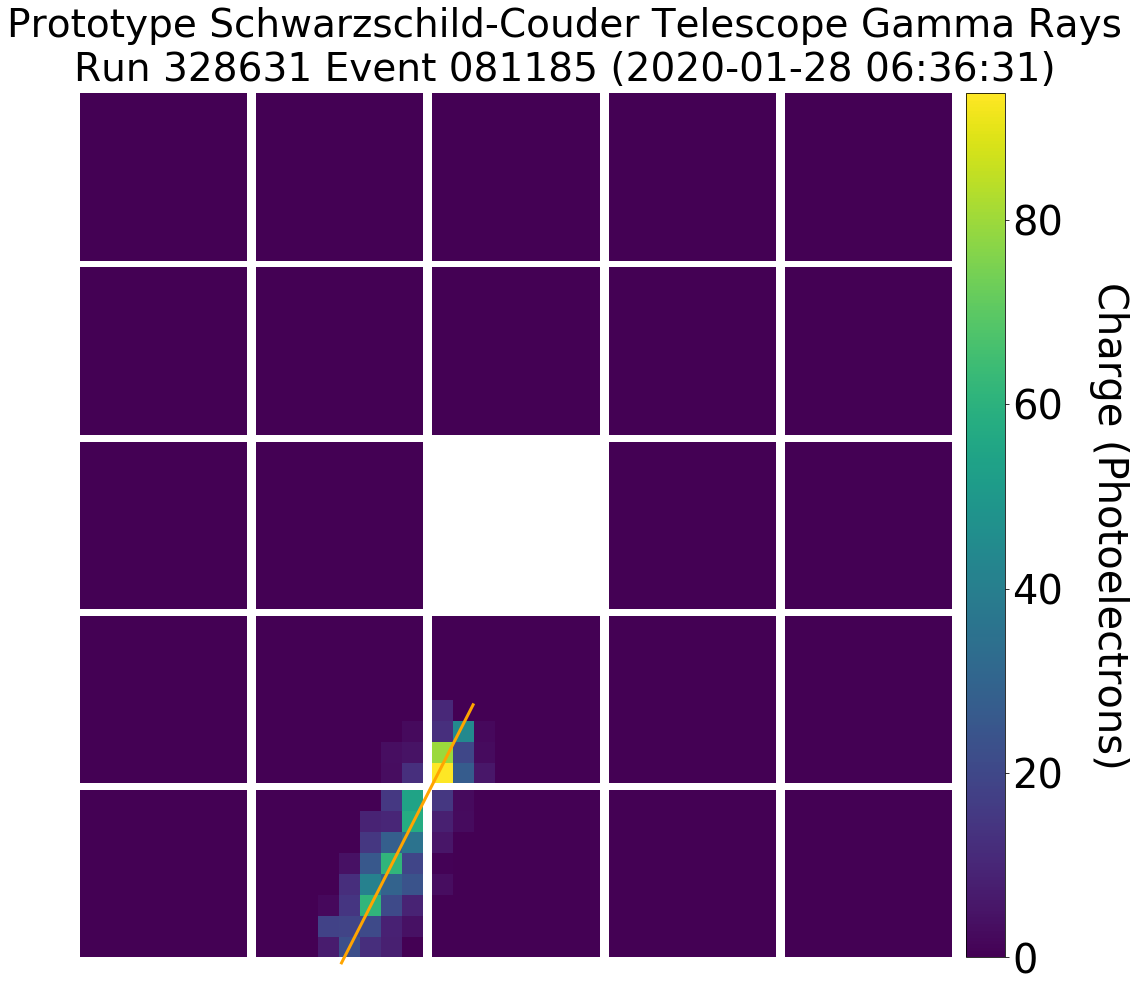

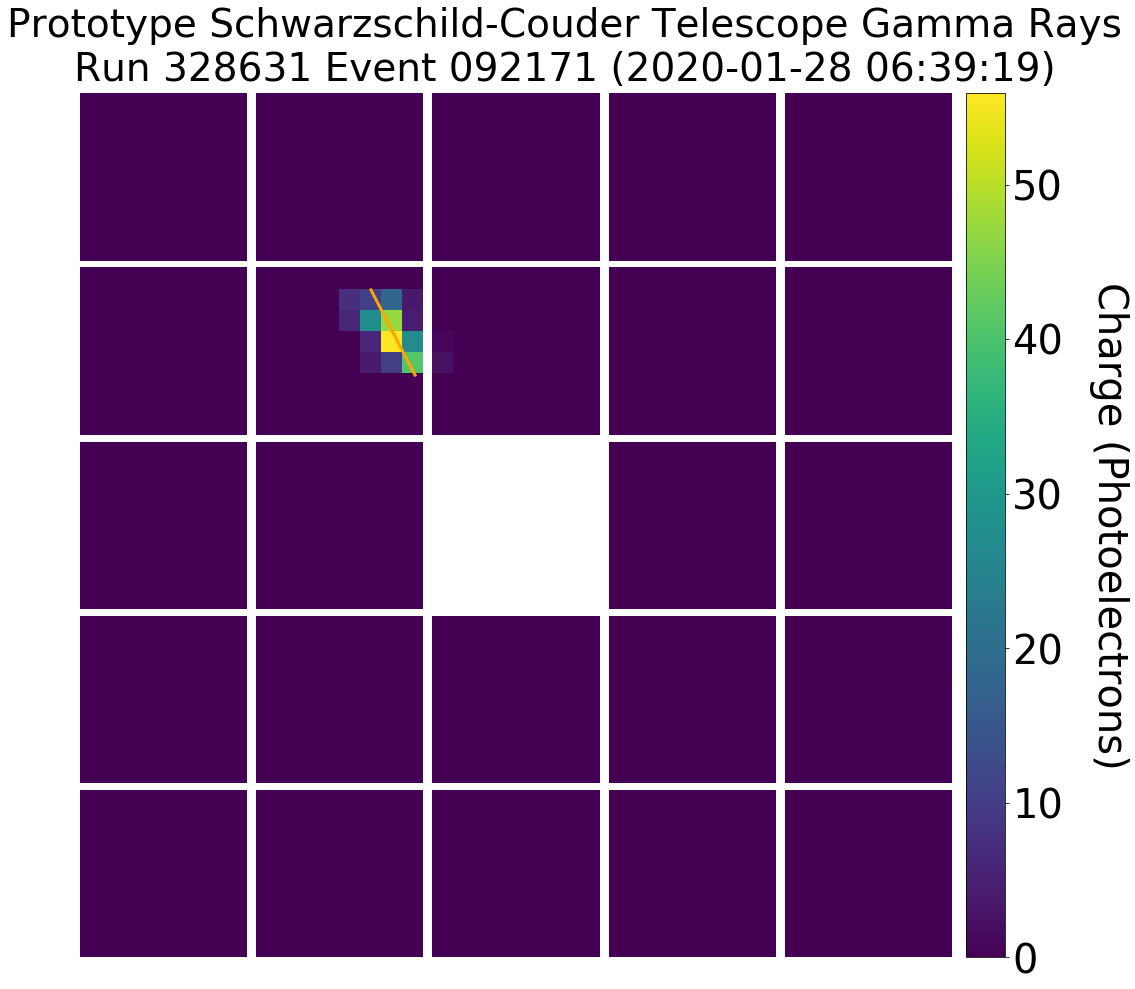

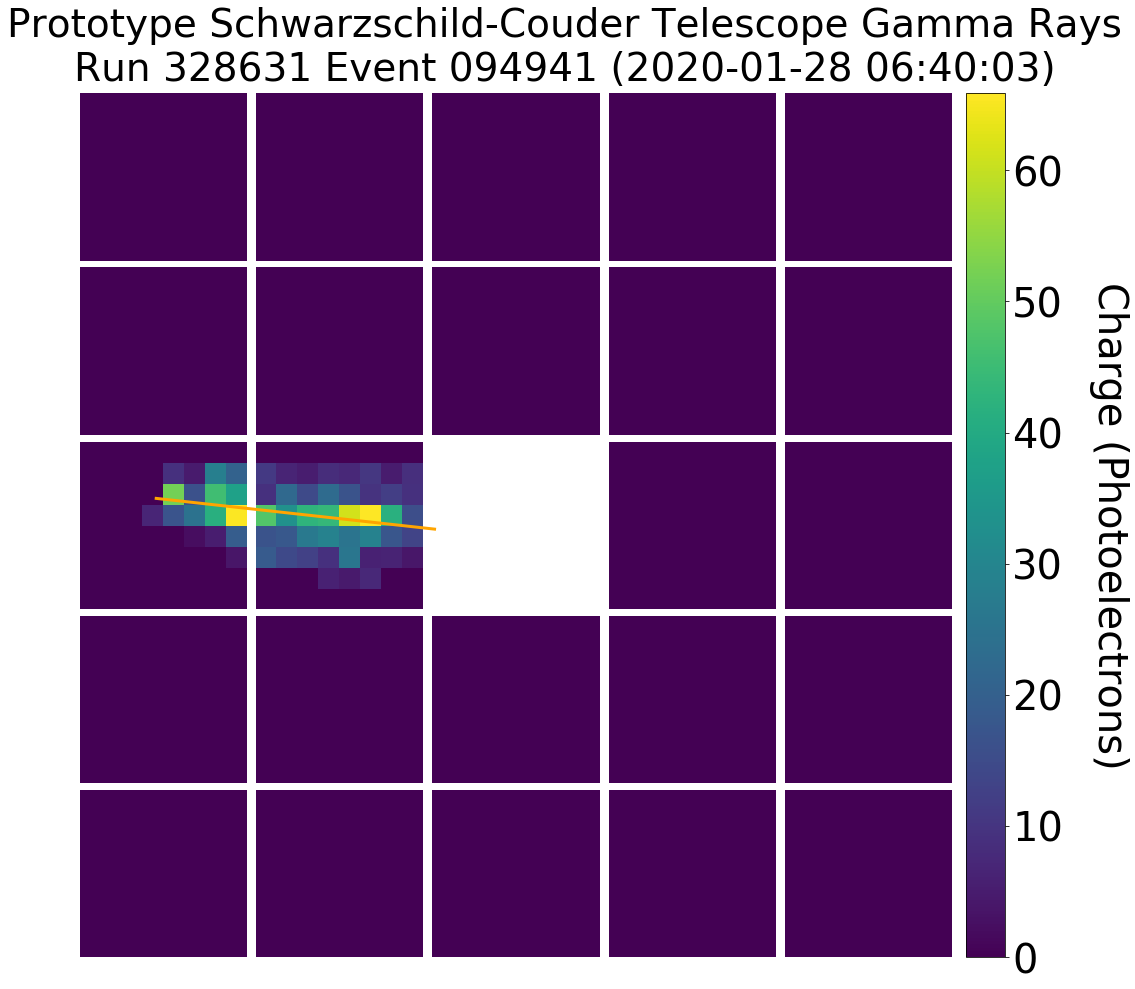

In [86]:
for tup in run_ev:
    noise_averages = np.load("noise_averages.npz")["arr_0"]
    reader = target_io.WaveformArrayReader(f"/home/bmode/cam_data/cal{tup[0]}.r1")
    n_pixels = reader.fNPixels
    n_samples = reader.fNSamples
    waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
    reader.GetR1Event(int(tup[1]), waveforms)
    reader.GetTimeStamp(int(tup[1]))
    time_stamp = int(reader.fCPU_s)
    time_str = datetime.utcfromtimestamp(time_stamp).strftime("%Y-%m-%d %H:%M:%S")
    peak_positions = np.argmax(waveforms, axis=1)
    charges = mcs.calculate_charge(waveforms, peak_positions, n_samples)
    charges = apply_gains(charges)
    no_charge = [val for val in charges if val == 0.0]
    if len(no_charge) > 750:
        print(tup)
        continue
    image = clean_image(charges, grid_ind, noise_averages)
    image = clean_image(charges, grid_ind, noise_averages)
    charge_coords = [[i - 19.5 + 0.42 * ((i // 8) - 2), 
                      j - 19.5 + 0.32 * ((j // 8) - 2),
                      image[j, i]] 
                      for i in range(40) for j in range(40)]
    h_params = hillas(np.asarray(charge_coords).T)
    camera_image(image, tup[0], int(tup[1]), time_str, h_params, keep=True)
    plt.show()

In [87]:
images = []
for tup in run_ev:
    if tup != (328629, 201231.0):
        ev = str(int(tup[1])).rjust(6, "0")
        images.append(imageio.imread(f"gamma_animation_hillas_v2/run{tup[0]}_ev{ev}.png"))

imageio.mimsave(f"gamma_animation_hillas_v2/pSCT_gammas_hillas.gif", images, duration=1)